

# **Importing Necessary Libraries**

In [ ]:
import os
import numpy as np
import cv2 as cv
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

In [ ]:
train = "/content/drive/MyDrive/Datasets/Flowers"

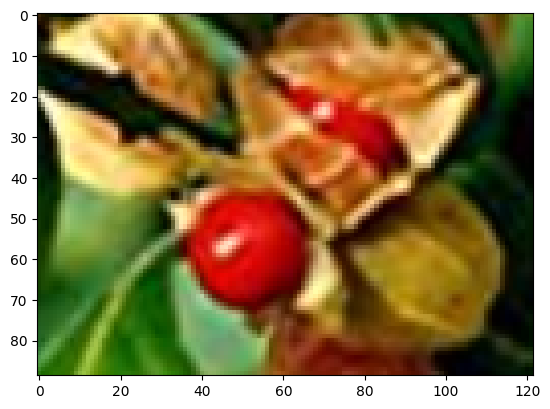

In [ ]:
img = cv.imread('/content/drive/MyDrive/Datasets/Flowers/ashwagandha/10.PNG')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
TRAINING_DIR = train
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

Found 178 images belonging to 3 classes.


# Model Building

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
densenet_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet_base_model.trainable = False


densenet_global_avg_pooling = GlobalAveragePooling2D()(densenet_base_model.output)
densenet_output = Dense(3, activation='softmax')(densenet_global_avg_pooling)
densenet_model = Model(inputs=densenet_base_model.input, outputs=densenet_output)


densenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-7)

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

# Training

In [ ]:
densenet_hist = densenet_model.fit(
            train_generator,
            # validation_data=validation_generator,
            epochs=150,
            verbose=1,
            #callbacks = [early_stopping, lr_scheduler]
            )

Epoch 1/150
12/12 [==============================] - 111s 8s/step - loss: 0.9837 - accuracy: 0.4888
Epoch 2/150
12/12 [==============================] - 5s 439ms/step - loss: 0.5717 - accuracy: 0.7753
Epoch 3/150
12/12 [==============================] - 5s 456ms/step - loss: 0.4085 - accuracy: 0.9101
Epoch 4/150
12/12 [==============================] - 3s 284ms/step - loss: 0.2905 - accuracy: 0.9663
Epoch 5/150
12/12 [==============================] - 4s 343ms/step - loss: 0.2517 - accuracy: 0.9494
Epoch 6/150
12/12 [==============================] - 3s 245ms/step - loss: 0.2093 - accuracy: 0.9607
Epoch 7/150
12/12 [==============================] - 3s 252ms/step - loss: 0.1855 - accuracy: 0.9607
Epoch 8/150
12/12 [==============================] - 4s 309ms/step - loss: 0.1812 - accuracy: 0.9494
Epoch 9/150
12/12 [==============================] - 4s 315ms/step - loss: 0.1527 - accuracy: 0.9719
Epoch 10/150
12/12 [==============================] - 3s 289ms/step - loss: 0.1427 - accurac

# Model Visualization

In [ ]:
history = densenet_hist

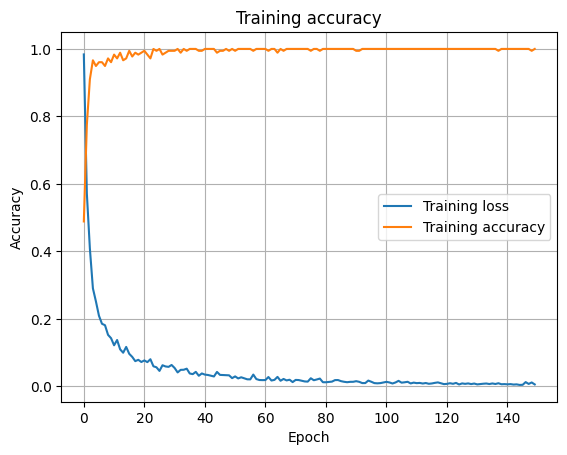

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy
train_loss = history.history['loss']
#val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.plot(train_loss, label='Training loss')
#plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
# plt.show()

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
#plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.grid()
plt.show()

# Saving the model

In [ ]:
densenet_model.save('/content/drive/MyDrive/Datasets/Flowers/densenet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Loading and Validation of model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Datasets/Flowers/densenet.h5")

In [ ]:
import cv2 as cv
import numpy as np


def categorise(image_path):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    img = cv.resize(img, (224,224))
    img = np.reshape(img, [1,224,224,3])
    img = img/255
    preds = model.predict(img)
    print(preds)
    max_idx = np.argmax(preds)
    class_indices = {v:k for k,v in train_generator.class_indices.items()}
    print(class_indices[max_idx])
    print(np.max(tf.nn.softmax(preds[0])))

In [ ]:
train_generator.class_indices.items()

dict_items([('ashwagandha', 0), ('cardamom', 1), ('madagascar', 2)])

1/1 [==============================] - 4s 4s/step
[[9.9998438e-01 1.5652413e-05 3.0884980e-08]]
ashwagandha
0.57611114


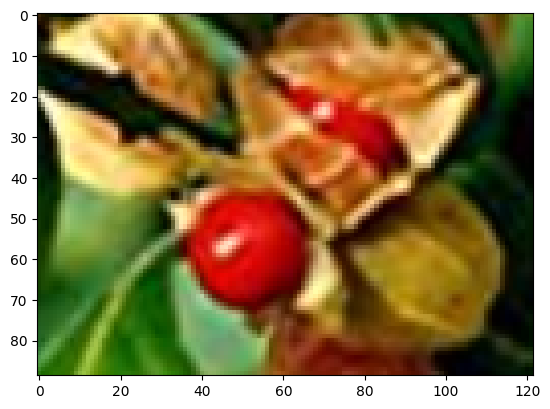

In [ ]:
#ashwagandah
path = "/content/drive/MyDrive/Datasets/Flowers/ashwagandha/10.PNG"
categorise(path)

1/1 [==============================] - 0s 43ms/step
[[1.0331518e-05 9.9998951e-01 8.8027726e-08]]
cardamom
0.57611305


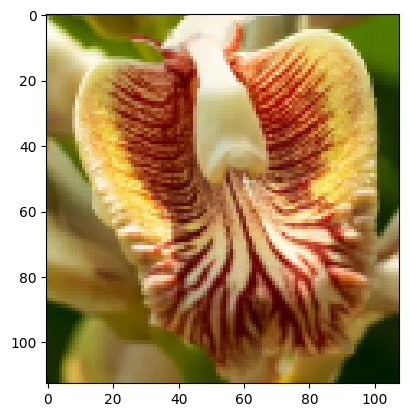

In [ ]:
#cardamom
path = "/content/drive/MyDrive/Datasets/Flowers/cardamom/10.png"
categorise(path)

1/1 [==============================] - 0s 59ms/step
[[1.6702079e-05 2.6390628e-05 9.9995685e-01]]
madagascar
0.57610106


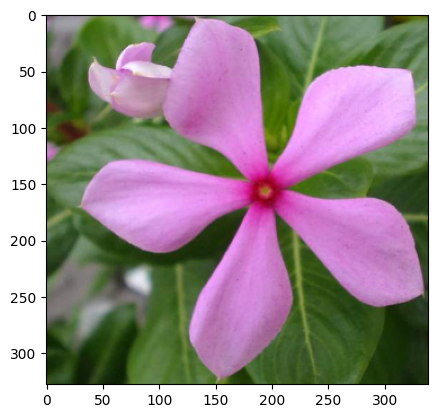

In [ ]:
#madagascar
path = "/content/drive/MyDrive/Datasets/Flowers/madagascar/10.PNG"
categorise(path)